# Bibliothèque

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import matplotlib.pyplot as plt
from scipy.io import  wavfile as wav
from IPython.display import display, Audio

# Lecture des fichier sonore

In [3]:
Fe, signal = wav.read("a.wav")
display(Audio(signal, rate=Fe))

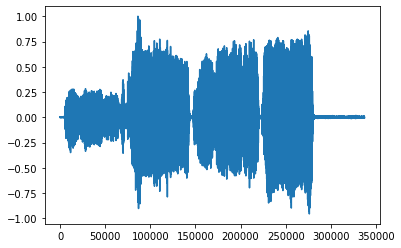

In [4]:
signal = signal / signal.max()
plt.plot(signal)

# Découpage du signal en trame

In [27]:
Te = 1/Fe
N = len(signal)
# Calcul du nombre d'echantillons par trame de 20 ms
n_trame = int(20*10**(-3) / Te)
nb_trame = int(N/n_trame)
Nwin = int(20*1e-3 / Te)
Nhop = int(Nwin//2)

print("Nwin =",Nwin)
print("Nhop =",Nhop)

Nwin = 882
Nhop = 441


# Fonction pour découper en trame et fenetrer un signal

In [6]:
def dec_trame(signal, Fe, temps_trame, Nhop):

    Te = 1/Fe
    N = len(signal)
    
    # Calcul du nombre d'echantillons par trame de 20 ms
    Nwin = int(temps_trame / Te)

    # Nombre de trames
    nb_trame = int((N - Nwin)//Nhop)
    
    # Découage  en trame de temps_trame
    signal_trame = np.zeros((nb_trame + 1, Nwin))
    for i in range(nb_trame + 1):
        signal_trame [i, :] = signal[i*Nhop: Nwin + i*Nhop]*np.hamming(Nwin)

    return  signal_trame

In [7]:
sf = dec_trame(signal, Fe, 20*10**(-3), Nhop)
print("vocal signal shape: ",sf.shape)

vocal signal shape:  (763, 882)


# Construire la Matrice $R_{pk}$

In [8]:
def mat_rpk(signal_trame, K=4):
  K = K
  Rpk = np.zeros((signal_trame.shape[0],2*K, 2*K))
  Rp = np.zeros((signal_trame.shape[0], 2*K))
  ak = np.zeros((signal_trame.shape[0], 2*K))

  for i in range(len(signal_trame)):
      for p in range(2*K):
          for k in range(2*K):
              for e in range(len(signal_trame[i])):
                  if (e-p) >= 0 and (e-k)>= 0:
                      Rpk[i,p,k] += signal_trame[i, e-p] *signal_trame[i, e-k]

  return Rpk           

In [33]:
Rpk = mat_rpk(sf)

In [9]:
def mat_rp(signal_trame):
  Rp = np.zeros(( signal_trame.shape[0], 8))
  for i in range(len(Rpk)):
      for p in range(8):
          for e in range(len(signal_trame[i])):
              if e-p >= 0:
                  Rp[i,p] += signal_trame[i, e-p] *signal_trame[i, e]
              else:
                  Rp[i,p] = 0
                   
  return Rp            

In [35]:
Rp = mat_rp(sf)
ak = np.zeros((sf.shape[0], 8))
index = 1
for index in range(len(ak)):
  ak[index] = np.dot(np.linalg.inv(Rpk[index]),(-Rp[index]))


# Algorithme Durbin-Levinson

In [10]:
# initialisation des vecteurs
def durbin_levinson(signal_trame,Rpk, kk=4 ):
  K = kk
  ak = np.zeros((signal_trame.shape[0], 2*K))
  E = np.zeros((2*K))

  # Initialisation des a0 à 1 sur toutres les trames
  ak[:,0] = 1
  for t in range(len(Rpk)):
    E[0] = Rpk[t, 0, 0]
    for i in range(1, 2*K):
      sum = 0
      ki = Rpk[t,i,i]
      for j in range(i-1):
        sum += ak[t, i-1]*Rpk[t,  np.abs(i-j), np.abs(i-j)]
      sum = (1/E[i-1])* (Rpk[t, i, i] - sum)

      ak[t, i] = ki
      ak[t,0:i+1]
      for z in range(1, i+1):
        ak[t,z] = ak[t,z-1] - ki* ak[t, z - i]   

      E[i] = (1 - ki**2)* E[i-1]

  return ak, E

In [11]:
def mat_rpk_diag(signal_trame, K=4):
  # Ordre du filtre est 2*K
  K = K
  Rpk = np.zeros((signal_trame.shape[0],2*K, 2*K))
  Rp = np.zeros((signal_trame.shape[0], 2*K))
  ak = np.zeros((signal_trame.shape[0], 2*K))

  for i in range(len(signal_trame)):
      for p in range(2*K):
          for k in range(2*K):
              for e in range(len(signal_trame[i])):
                  if np.abs(k-p) <= e:
                      Rpk[i,p,k] += signal_trame[i, e] *signal_trame[i, e- np.abs(k-p)]

  return Rpk   

In [12]:
Rpk_diag = mat_rpk_diag(sf)
ak, sigma = durbin_levinson(sf, Rpk_diag)

# Fonction de trasfert du filtre

In [13]:
def H(z,trame):
  som = 0
  for i in range(1,len(trame)):
    som += trame[i]*z**(-i)

  H = 1/(1-som)
  return H


def Hf(f, T, trame):
  xf = H(np.exp(-2j*np.pi*f*T), trame)
  return xf
  

In [14]:
h = np.zeros((ak.shape[0], 1024))
f = np.linspace(-Fe/2,Fe/2, 1024)
for t in range(len(h)):
  h[t] = Hf(f, 1/Fe, ak[t])

del t

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


In [15]:
# convolution discrete
def conv(x, h):
  y = np.copy(x)
  for t in range(x.shape[0]):
    som = 0
    for n in range(8, len(y[t])):
      for i in range(h.shape[1]):
        som += h[t,i] * x[t, n-i]
      
      y[t, n] = som

  return y


# Appliquer le filtre au signal musical 

In [32]:
Fe2, saxo = wav.read("saxo.wav")
saxo_trame = dec_trame(signal, Fe2, 20*10**(-3), Nhop)
print("music signal shape: ", saxo_trame.shape)
display(Audio(saxo, rate=Fe2))

music signal shape:  (763, 882)


In [40]:
saxo_trame = saxo_trame/saxo_trame.max()
saxo_trame.shape

(763, 882)

In [41]:
signal_filtre = conv(saxo_trame, ak)
signal_filtre.shape


(763, 882)

In [42]:
x = np.zeros((signal_filtre.shape[0], signal_filtre.shape[0]*Nhop + Nwin))
x_vect = np.zeros((signal_filtre.shape[0]*Nhop + Nwin))

for k in range(signal_filtre.shape[0]):
  x[k,k*Nhop: k*Nhop + Nwin] = signal_filtre[k, :]

for k in range(signal_filtre.shape[0]):
  x_vect += x[k,:] 
  K = np.sum(np.hamming(Nwin))/Nhop

x_vect = x_vect/K

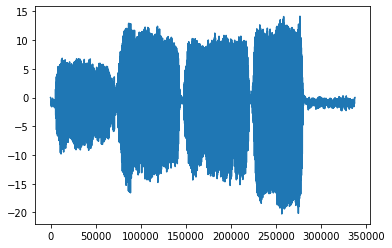

In [43]:
plt.plot(x_vect)

In [44]:
display(Audio(x_vect, rate=Fe))